In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
data_dir = "/content/gdrive/MyDrive/Batik Dataset Enhanched/Batik"

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=270,
                                   zoom_range=0.2,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='wrap',
                                   validation_split=0.25)


In [15]:
train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(data_dir,
                                                         target_size=(224, 224),
                                                         color_mode='rgb',
                                                         shuffle=False,
                                                         class_mode='categorical',
                                                         subset='validation')

Found 772 images belonging to 20 classes.
Found 244 images belonging to 20 classes.


In [8]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', pooling="max",
    classifier_activation=None
)

model = tf.keras.models.Sequential()

"""for layer in base_model.layers[:-1]:
    model.add(layer)  """  

# Freeze the layers 
for layer in base_model.layers[:-1]:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(base_model)
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(20, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                40980     
Total params: 21,843,764
Trainable params: 40,980
Non-trainable params: 21,802,784
_________________________________________________________________


In [9]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["acc"])

In [10]:
class myCallback(tf.keras.callbacks.Callback):
        # Your Code
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('acc')>0.95):
                print("\nReached 95% so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

In [11]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=500, steps_per_epoch=15, callbacks=[callbacks])

Epoch 1/500
15/15 [==============================] - 452s 29s/step - loss: 5.7291 - acc: 0.0625 - val_loss: 3.7545 - val_acc: 0.0943
Epoch 2/500
15/15 [==============================] - 119s 8s/step - loss: 4.6349 - acc: 0.0979 - val_loss: 3.2457 - val_acc: 0.1639
Epoch 3/500
15/15 [==============================] - 51s 3s/step - loss: 3.8826 - acc: 0.1770 - val_loss: 2.8604 - val_acc: 0.1967
Epoch 4/500
15/15 [==============================] - 30s 2s/step - loss: 3.7073 - acc: 0.1875 - val_loss: 2.8055 - val_acc: 0.2582
Epoch 5/500
15/15 [==============================] - 25s 2s/step - loss: 3.2660 - acc: 0.2542 - val_loss: 2.7374 - val_acc: 0.3115
Epoch 6/500
15/15 [==============================] - 22s 2s/step - loss: 3.1372 - acc: 0.2854 - val_loss: 2.7509 - val_acc: 0.2951
Epoch 7/500
15/15 [==============================] - 20s 1s/step - loss: 3.1291 - acc: 0.2854 - val_loss: 3.0278 - val_acc: 0.3033
Epoch 8/500
15/15 [==============================] - 20s 1s/step - loss: 2.9720 

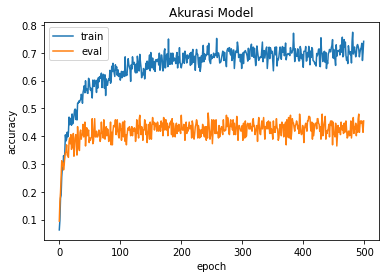

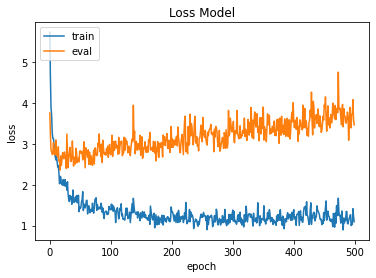

In [12]:
import matplotlib.pyplot as plt

# Accuracy plotting
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

# Loss plotting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

In [13]:
tf.saved_model.save(model, "BatikClassificationV4-InceptionV3")


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: BatikClassificationV4-InceptionV3/assets


In [14]:
!zip -r /content/BatikClassificationV4-InceptionV3.zip /content/BatikClassificationV4-InceptionV3

  adding: content/BatikClassificationV4-InceptionV3/ (stored 0%)
  adding: content/BatikClassificationV4-InceptionV3/saved_model.pb (deflated 93%)
  adding: content/BatikClassificationV4-InceptionV3/assets/ (stored 0%)
  adding: content/BatikClassificationV4-InceptionV3/variables/ (stored 0%)
  adding: content/BatikClassificationV4-InceptionV3/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/BatikClassificationV4-InceptionV3/variables/variables.index (deflated 76%)


In [16]:
label = []
import os
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        label.append(os.path.join(dirname, filename).split('/')[-2])

labels = np.unique(label)
ints = np.arange(0, len(label))
dicts = dict(zip(labels, ints))
dicts

{'batik-bali': 0,
 'batik-betawi': 1,
 'batik-celup': 2,
 'batik-cendrawasih': 3,
 'batik-ceplok': 4,
 'batik-ciamis': 5,
 'batik-garutan': 6,
 'batik-gentongan': 7,
 'batik-kawung': 8,
 'batik-keraton': 9,
 'batik-lasem': 10,
 'batik-megamendung': 11,
 'batik-parang': 12,
 'batik-pekalongan': 13,
 'batik-priangan': 14,
 'batik-sekar-jagad': 15,
 'batik-sidoluhur': 16,
 'batik-sidomukti': 17,
 'batik-sogan': 18,
 'batik-tambal': 19}

In [17]:
y_true = validation_generator.classes

print(y_true)

[ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  6
  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  8
  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11
 11 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 15 15 15 15 16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17
 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19
 19 19 19 19]


In [18]:
predictions = model.predict(validation_generator)
y_pred = np.rint(predictions)
y_pred = np.argmax(y_pred, axis=1)

print(y_pred)

[ 0  0  0 17  1  0  3  3 10  0  0  0  0  1  6  1  1  1  1  1  6  1  1  1
 10  2  2  2  2  2  2  2  2  2  2  2  0  3 17  3  0  3 18 10  3  1  2  3
  8  9 16 10  0  8  9  4  4 17 17  1 17 13  4  0 14  3  6 17 14  0  0  0
  6 16 16 12 14 17  2  6  8  6 14  0  3  7  0  7 17 13 12  1  5  5  0  8
  8  8  4  8  8  8  8  8  8  8  8 14  0  6 12 18  0  0  3 18  9 12 10  0
 18  0 10 10 10 10  0 13 10  0 13 13  3 11 11 11 11 11  6 11 11 11 11 11
 11 12 17 12 12 12 18 12 11 12 12 12 12  9  9  0 13  0  0 17  3  8 13  0
  0  1 10 14  0 14 14  6 14  0  0 14  0  0  0  0  0  0 10  0  0 15 15 17
 15 19 17 15 17 17 17 17 17  5 18 14 17 17 16 17 18  0 16 17 18  1 17 17
 17 18 17  0  0  6 12  0 18  0  0 17 18 18  3  0 17 12 19  6 17 19 19 17
 19 19 19 19]


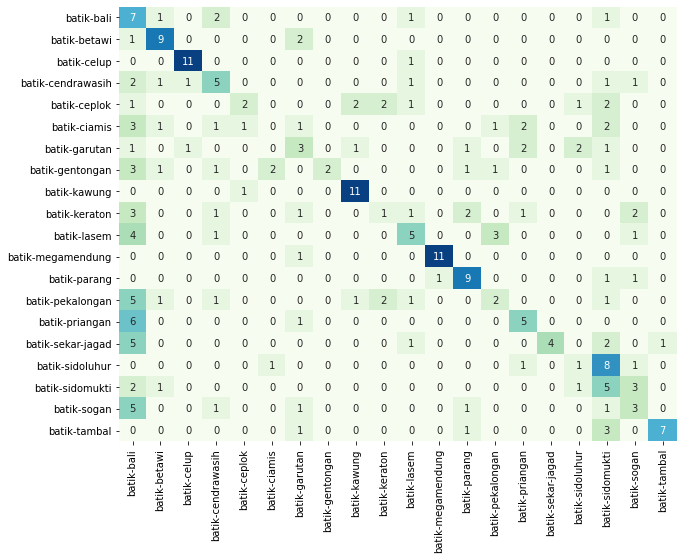

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='GnBu', cbar=False)
plt.xticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=90)
plt.yticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=0)
plt.show()

In [20]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.58      0.23        12
           1       0.60      0.75      0.67        12
           2       0.85      0.92      0.88        12
           3       0.38      0.42      0.40        12
           4       0.50      0.18      0.27        11
           5       0.00      0.00      0.00        12
           6       0.27      0.25      0.26        12
           7       1.00      0.17      0.29        12
           8       0.73      0.92      0.81        12
           9       0.20      0.08      0.12        12
          10       0.42      0.36      0.38        14
          11       0.92      0.92      0.92        12
          12       0.60      0.75      0.67        12
          13       0.29      0.14      0.19        14
          14       0.45      0.42      0.43        12
          15       1.00      0.31      0.47        13
          16       0.20      0.08      0.12        12
          17       0.17    